# Court Homography

In this Notebook the Homography calculation is implemented.

Furthermore using the Homography the player positions and bounces are analyzed

### imports

In [5]:
import pandas as pd
import numpy as np
import json
import xml.etree.ElementTree as ET
import json
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
import matplotlib.lines as mlines
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter

## create court model

In [6]:
def draw_court(img_width, img_height, court_color, line_color, line_thickness = 5):

    image = np.full((img_height, img_width, 3), court_color, dtype=np.uint8)

    # Define court and margin sizes directly in pixels
    court_length = 2377  # Court length in pixels (vertical)
    court_width_doubles = 1097  # Doubles court width in pixels (horizontal)
    court_width_singles = 823  # Singles court width in pixels (horizontal)
    service_line_dist = 640  # Distance from baseline to service line in pixels

    # Margins in pixels
    baseline_margin = 600  # 6 meters top and bottom margin
    sideline_margin = 350  # 3.5 meters left and right margin

    

    # Calculate court boundaries with margins
    top_margin = baseline_margin
    bottom_margin = img_height - baseline_margin
    left_margin = sideline_margin
    right_margin = img_width - sideline_margin -1

    # Functions to draw horizontal and vertical lines with precise thickness
    def draw_horizontal_line(image, x1, y1, x2, y2, color, thickness):
        for i in range(thickness):
            cv2.line(image, (x1, y1 + i), (x2, y2 + i), color, 1)

    def draw_vertical_line(image, x1, y1, x2, y2, color, thickness):
        for i in range(thickness):
            cv2.line(image, (x1 + i, y1), (x2 + i, y2), color, 1)

    # Draw the baselines (top and bottom of the court)
    draw_horizontal_line(image, left_margin, top_margin, right_margin, top_margin, line_color, line_thickness)
    draw_horizontal_line(image, left_margin, bottom_margin-5, right_margin, bottom_margin-5, line_color, line_thickness)

    # Draw the doubles sidelines (left and right)
    draw_vertical_line(image, left_margin, top_margin, left_margin, bottom_margin-1, line_color, line_thickness)
    draw_vertical_line(image, right_margin-4, top_margin, right_margin-4, bottom_margin-1, line_color, line_thickness)

    # Draw the singles sidelines within the doubles court
    singles_left = left_margin + 132  # 1.37 meters from the doubles sideline without line
    singles_right = right_margin - 136 # 1.37 meters from the doubles sideline without line
    draw_vertical_line(image, singles_left, top_margin, singles_left, bottom_margin-1, line_color, line_thickness)
    draw_vertical_line(image, singles_right, top_margin, singles_right, bottom_margin-1, line_color, line_thickness)

    # Draw the service lines (6.4 m from image height middle)
    service_top = img_height // 2 - service_line_dist
    service_bottom = img_height // 2 + service_line_dist

    draw_horizontal_line(image, singles_left, service_top, singles_right, service_top, line_color, line_thickness)
    draw_horizontal_line(image, singles_left, service_bottom-5, singles_right, service_bottom-5, line_color, line_thickness)

    # Draw the center service line (vertical)
    center_x = img_width // 2
    draw_vertical_line(image, center_x-2, service_top, center_x-2, service_bottom-1, line_color, line_thickness)

    # Draw center marks on the baselines (0.1 meter or 10 cm long)
    center_mark_length = 10  # 10 pixels
    draw_vertical_line(image, center_x-2, top_margin+4, center_x-2, top_margin + center_mark_length, line_color, line_thickness)
    draw_vertical_line(image, center_x-2, bottom_margin - center_mark_length, center_x-2, bottom_margin-6, line_color, line_thickness)


    net_y = img_height // 2

    def draw_dotted_horizontal_line(image, x1, y, x2, color, thickness, dot_length=10, gap_length=10):
        current_x = x1
        while current_x < x2:
            end_x = min(current_x + dot_length, x2)  # Ensure we don’t go beyond x2
            cv2.line(image, (current_x, y), (end_x, y), color, thickness)
            current_x += dot_length + gap_length

    draw_dotted_horizontal_line(image, left_margin-91, net_y, right_margin+91, (0, 0, 0), line_thickness)

    return image

# Set the image size (1797 x 3577 pixels)
img_width = 1797
img_height = 3577

# Create a blank image with the court color #E3783B
court_color = (59, 120, 227)  # OpenCV uses BGR, so #E3783B is (59, 120, 227)
line_color = (255, 255, 255)  # White lines

court_clay = draw_court(img_width, img_height, court_color, line_color)
court_white = draw_court(img_width, img_height, (255, 255, 255), (0, 0, 0))

# Save the image
cv2.imwrite("tennis_court_with_precise_lines.png", court_clay)
cv2.imwrite("tennis_court_with_precise_lines_white.png", court_white)

True

In [ ]:
# one with thicker lines
court_clay = draw_court(img_width, img_height, court_color, line_color, 15)


# Add a black border as padding within the original dimensions
border_thickness = 10  # Thickness of the border
canvas_height, canvas_width = court_clay.shape[:2]

# Scale down the original content to make space for the padding
scaled_content = cv2.resize(court_clay, (canvas_width - 2 * border_thickness, canvas_height - 2 * border_thickness))

# Create a black canvas of the same size as the original image
padded_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Overlay the scaled-down content on the black canvas
padded_canvas[
    border_thickness:border_thickness + scaled_content.shape[0],
    border_thickness:border_thickness + scaled_content.shape[1]
] = scaled_content

# Save the image
cv2.imwrite("tennis_court_with_precise_lines_thicker.png", padded_canvas)

True

### Defining functions for Homography

In [7]:
mp_dict = {
    'top_left_corner': [352,602],
    'top_left_singles': [484,602],
    'top_right_singles': [1312,602],
    'top_right_corner': [1444,602],
    'bottom_left_corner': [352,2974],
    'bottom_left_singles': [484,2974],
    'bottom_right_singles': [1312,2974],
    'bottom_right_corner': [1444,2974],
    'service_top_left': [484,1150],
    'service_top_right': [1312,1150],
    'service_bottom_left': [484,2425],
    'service_bottom_right': [1312,2425],
    'service_center_top': [898,1150],
    'service_center_bottom': [898,2425],
}

# read annotation json
with open('../00_Dataset/annotations.json') as f:
    data = json.load(f)

model_court = cv2.imread('tennis_court_with_precise_lines.png')

In [9]:
def order_lines(lines):
    # Sort vertical lines (left to right) by the average x-coordinate of the endpoints
    vertical_lines = sorted(
        lines['vertical'],
        key=lambda line: (line['x1'] + line['x2']) / 2
    )

    # Sort horizontal lines (top to bottom) by the average y-coordinate of the endpoints
    horizontal_lines = sorted(
        lines['horizontal'],
        key=lambda line: (line['y1'] + line['y2']) / 2
    )
    
    return {'horizontal': horizontal_lines, 'vertical': vertical_lines}

def split_horizontal_vertical(lines, threshold=10):
    horizontal_lines = []
    vertical_lines = []

    for line in lines:
        x1, y1, x2, y2 = line['x1'], line['y1'], line['x2'], line['y2']
        
        # Calculate the angle of the line in degrees
        dx = x2 - x1
        dy = y2 - y1
        angle = abs(math.degrees(math.atan2(dy, dx)))

        # Classify between horizontal and vertical lines assuming an almost horzontal camera orientation 
        if angle < threshold or angle > 180-threshold:
            # Angle closer to 0 or 180 degrees -> horizontal
            horizontal_lines.append(line)
        else:
            # Angle closer to 90 or -90 degrees -> vertical
            vertical_lines.append(line)

    ordered_lines = order_lines({'horizontal': horizontal_lines, 'vertical': vertical_lines})

    return ordered_lines

def calculate_line_intersection(line1, line2):
    x1, y1, x2, y2 = line1['x1'], line1['y1'], line1['x2'], line1['y2']
    x3, y3, x4, y4 = line2['x1'], line2['y1'], line2['x2'], line2['y2']
    
    # Berechnung des Determinanten
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    # Überprüfung, ob die Linien parallel sind
    if denom == 0:
        return None  # Die Linien sind parallel und haben keinen Schnittpunkt
    
    # Berechnung des Schnittpunkts mit Hilfe des Cramer'schen Regel
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

    # pixel int
    intersect_x = int(intersect_x)
    intersect_y = int(intersect_y)

    return (intersect_x, intersect_y)

def get_ordered_keypoints_from_line(lines):
    # check if all lines are present
    if len(lines['horizontal']) != 4:
        return None
    if len(lines['vertical']) != 5:
        return None
    
    p_dict = {}

    # top left corner
    p_dict['top_left_corner'] = calculate_line_intersection(lines['horizontal'][0], lines['vertical'][0])
    # top left singles
    p_dict['top_left_singles'] = calculate_line_intersection(lines['horizontal'][0], lines['vertical'][1])
    # top right singles
    p_dict['top_right_singles'] = calculate_line_intersection(lines['horizontal'][0], lines['vertical'][3])
    # top right corner
    p_dict['top_right_corner'] = calculate_line_intersection(lines['horizontal'][0], lines['vertical'][4])
    # bottom left corner
    p_dict['bottom_left_corner'] = calculate_line_intersection(lines['horizontal'][3], lines['vertical'][0])
    # bottom left singles
    p_dict['bottom_left_singles'] = calculate_line_intersection(lines['horizontal'][3], lines['vertical'][1])
    # bottom right singles
    p_dict['bottom_right_singles'] = calculate_line_intersection(lines['horizontal'][3], lines['vertical'][3])
    # bottom right corner
    p_dict['bottom_right_corner'] = calculate_line_intersection(lines['horizontal'][3], lines['vertical'][4])
    # service top left
    p_dict['service_top_left'] = calculate_line_intersection(lines['horizontal'][1], lines['vertical'][1])
    # service top right
    p_dict['service_top_right'] = calculate_line_intersection(lines['horizontal'][1], lines['vertical'][3])
    # service bottom left
    p_dict['service_bottom_left'] = calculate_line_intersection(lines['horizontal'][2], lines['vertical'][1])
    # service bottom right
    p_dict['service_bottom_right'] = calculate_line_intersection(lines['horizontal'][2], lines['vertical'][3])
    # service center top
    p_dict['service_center_top'] = calculate_line_intersection(lines['horizontal'][1], lines['vertical'][2])
    # service center bottom
    p_dict['service_center_bottom'] = calculate_line_intersection(lines['horizontal'][2], lines['vertical'][2])

    return p_dict

In [10]:
def transform_points_to_model(points, matrix):
    transformed_points = []
    for point in points:
        # Convert the point to the required format for perspectiveTransform
        input_point = np.array([[[point[0], point[1]]]], dtype=np.float32)
        
        # Transform the point using the homography matrix
        model_point = cv2.perspectiveTransform(input_point, matrix)
        
        # Extract the x and y from the transformed result
        x, y = model_point[0][0][0], model_point[0][0][1]
        transformed_points.append((int(x), int(y)))  # Convert to integer for pixel coordinates
    
    return transformed_points

def draw_points_on_model(model_court, points, point_color=(255, 0, 0), point_radius=10, putText=True):
    # Make a copy of the model court image to draw on
    model_court_copy = model_court.copy()
    for i, point in enumerate(points):
        x, y = point
        # Check bounds to ensure we don’t draw outside the image
        if 0 <= x < model_court_copy.shape[1] and 0 <= y < model_court_copy.shape[0]:
            # Draw a circle at each point
            cv2.circle(model_court_copy, (x, y), point_radius, point_color, -1)
            if putText:
                #add text with point number
                cv2.putText(model_court_copy, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    
    return model_court_copy

def get_court_keypoints(video, clip):
    #get keypoints element
    first_key = list(data['subsets'][0]['videos'][video]['clips'][clip]['frames_with_objects'].keys())[0]
    keypoints = data['subsets'][0]['videos'][video]['clips'][clip]['frames_with_objects'][first_key]['keypoints'][0]['points']
    # remove keys where value is none
    keypoints = {k: v for k, v in keypoints.items() if v is not None}
    return keypoints

def get_existing_keypoints(keypoint_dict, model_keypoint_dict):
    # get iterate over model point dict and add all points in the correct order
    actual_existing_points = []
    model_existing_points = []
    for key in model_keypoint_dict.keys():
        if key in keypoint_dict.keys() and keypoint_dict[key] is not None:
            actual_existing_points.append(keypoint_dict[key])
            model_existing_points.append(model_keypoint_dict[key])

    # convert to numpy array
    actual_existing_points = np.array(actual_existing_points)
    model_existing_points = np.array(model_existing_points)

    return actual_existing_points, model_existing_points

def calculate_transfer_error(src_points, dst_points, homography):
    # Ensure src_points and dst_points are numpy arrays and have the correct shape
    src_points = np.array(src_points, dtype=np.float32).reshape(-1, 1, 2)
    dst_points = np.array(dst_points, dtype=np.float32).reshape(-1, 2)
    
    # Transform the src_points using the homography matrix
    projected_points = cv2.perspectiveTransform(src_points, homography).reshape(-1, 2)
    
    # Calculate Euclidean distance (reprojection error) for each point
    errors = np.linalg.norm(dst_points - projected_points, axis=1)**2
    
    # Calculate mean squared error
    mean_squared_error = np.mean(errors)
    return mean_squared_error


def get_homography_for_clip(video, clip, method=0):
     # get lines
    keypoint_dict = get_court_keypoints(video, clip)



    # get existing keypoints
    actual_existing_points, model_existing_points = get_existing_keypoints(keypoint_dict, mp_dict)

    # Compute the homography matrix using RANSAC for robustness
    keypoint_matrix, status = cv2.findHomography(actual_existing_points, model_existing_points, method)

    # calculate reprojection_error 
    transfer_error = calculate_transfer_error(actual_existing_points, model_existing_points, keypoint_matrix)

    return keypoint_matrix, actual_existing_points, transfer_error

def get_bounce_positions(video, clip):
    # get all bounce positions 
    bounce_positions= []
    for frame_number, frame in data['subsets'][0]['videos'][video]['clips'][clip]['frames_with_objects'].items():
        for ball in frame['balls']:
            if ball['trajectory'] == "Bounce":
                x = int(ball['x'])
                y = int(ball['y'])
                bounce_positions.append((x, y, frame_number))
    
    # check if two consectutive frames are in the positions
    for idx,position in enumerate(bounce_positions):
        if idx == len(bounce_positions)-1:
            break
        # check if consecutive frames
        if int(position[2]) != int(bounce_positions[idx+1][2])-1:
            # interpolate
            x1,y1,_ = position
            x2,y2,_ = bounce_positions[idx+1]

            #remove both items from list
            bounce_positions.pop(idx)
            bounce_positions.pop(idx)

           # Calculate the midpoint and add it as a single bounce position
            mid_x = (x1 + x2) // 2
            mid_y = (y1 + y2) // 2
            bounce_positions.insert(idx+1, (mid_x, mid_y, idx))

    # convert list so it only contains the points
    bounce_positions = [x[:2] for x in bounce_positions]

    return bounce_positions

# get player positions
def get_player_positions(video, clip):
    positions = []
    for frame_number, frame in data['subsets'][0]['videos'][video]['clips'][clip]['frames_with_objects'].items():
        for player in frame['players']:

            # Calculate bottom center
            bottom_center_x = (player['xtl'] + player['xbr']) // 2
            #if camera side moove slightly more towards the top
            if player['camera_side'] == 'true':
                bottom_center_y = player['ybr']
            else:
                bottom_center_y = player['ybr']

            positions.append((bottom_center_x, bottom_center_y))
    return positions

     
# perform homography
def plot_clip(video, clip, legend = True):

    #get homography
    homography, used_keypoints, transfer_error = get_homography_for_clip(video, clip)    

    # bounce positions
    bounce_positions = get_bounce_positions(video, clip)

    # player positions
    player_positions = get_player_positions(video, clip)

    # transform 
    transformed_bounces = transform_points_to_model(bounce_positions, homography)
    transformed_keypoints = transform_points_to_model(used_keypoints, homography)
    transformed_players = transform_points_to_model(player_positions, homography)

    # draw model with bounces
    model_with_ball_positions = draw_points_on_model(model_court, transformed_bounces, point_color=(0, 255, 255), putText=False, point_radius=20)
    model_with_keypoints = draw_points_on_model(model_with_ball_positions, transformed_keypoints, point_color=(52, 235, 97), putText=False, point_radius=10)
    model_with_players = draw_points_on_model(model_with_keypoints, transformed_players, point_color=(255, 0, 40), putText=False, point_radius=7)

    # Add text at the top center near the dashed line indicating camera side
    text_position = (model_with_players.shape[1] // 2 -190, model_with_players.shape[0]-50)  # Adjust these coordinates if needed
    cv2.putText(model_with_players, "Camera Side", text_position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

    # Rotate the final image by 90 degrees
    rotated_model_with_players = np.rot90(model_with_players)


    # Plot the model court with points
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(rotated_model_with_players, cv2.COLOR_BGR2RGB))
    plt.axis("off")  # Hide axis

    # Add a legend if requested
    if legend:
        # Define point markers for each object type (in BGR)
        bounce_marker = mlines.Line2D([], [], color=(255/255, 255/255, 0/255), marker='o', linestyle='None', markersize=12, label="Ball Bounces")
        keypoint_marker = mlines.Line2D([], [], color=(97/255, 235/255, 52/255), marker='o', linestyle='None', markersize=7, label="Court Keypoints")
        player_marker = mlines.Line2D([], [], color=(40/255, 0/255, 255/255), marker='o', linestyle='None', markersize=5, label="Player Positions")

        # Add legend to the plot in a single row with background color
        legend = plt.legend(handles=[bounce_marker, keypoint_marker, player_marker], loc="upper center", fontsize=10, ncol=3)
        legend.get_frame().set_facecolor('lightgrey')  # Set background color to light grey
        legend.get_frame().set_alpha(0.8)              # Set transparency level
        legend.get_frame().set_edgecolor('black')      # Set edge color for better visibility

        
    plt.show()
    print(f"Transfer error: {transfer_error:.2f} pixels")


In [12]:
# plot all bounces for an entire video
def get_all_transformed_bounces(video,):
    transformed_bounces = []
    for clip in range(len(data['subsets'][0]['videos'][video]['clips'])):
        homography, _, _ = get_homography_for_clip(video, clip)
        bounce_positions = get_bounce_positions(video, clip)
        transformed_bounces.extend(transform_points_to_model(bounce_positions, homography))
    return transformed_bounces, homography

def get_all_transformed_keypoints(video):
    transformed_keypoints = []    
    for clip in range(len(data['subsets'][0]['videos'][video]['clips'])):  

        keypoint_dict = get_court_keypoints(video, clip)
        actual_existing_points, _ = get_existing_keypoints(keypoint_dict, mp_dict)

        homography, _, _ = get_homography_for_clip(video, clip)

        transformed_keypoints.extend(transform_points_to_model(actual_existing_points, homography))
    return transformed_keypoints

def get_all_transformed_players(video):
    transformed_players = []
    for clip in range(len(data['subsets'][0]['videos'][video]['clips'])):
        homography, _, _ = get_homography_for_clip(video, clip)
        player_positions = get_player_positions(video, clip)
        transformed_players.extend(transform_points_to_model(player_positions, homography))
    return transformed_players


def plot_video(video, bounces=True, keypoints=False, players=False):
    copy = model_court.copy()
    if bounces:
        transformed_bounces, homography = get_all_transformed_bounces(video)
        copy = draw_points_on_model(copy, transformed_bounces, point_color=(0, 255, 255), putText=False)

    if keypoints:
        transformed_keypoints = get_all_transformed_keypoints(video)
        copy = draw_points_on_model(copy, transformed_keypoints, point_color=(52, 235, 97), putText=False)

    if players:
        transformed_players = get_all_transformed_players(video)
        copy = draw_points_on_model(copy, transformed_players, point_color=(255, 0, 40), putText=False)


    # Plot the model court with points
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
    plt.title("Model Court with Transformed Points")
    plt.axis("off")  # Hide axis
    plt.show()

In [15]:
# plot entire subset 
def plot_subset(bounces=True, keypoints=False, players=False):
    copy = model_court.copy()
    if bounces:
        for video in range(len(data['subsets'][0]['videos'])):
            transformed_bounces, homography = get_all_transformed_bounces(video)
            copy = draw_points_on_model(copy, transformed_bounces, point_color=(0, 255, 255), putText=False)

    if keypoints:
        for video in range(len(data['subsets'][0]['videos'])):
            transformed_keypoints = get_all_transformed_keypoints(video)
            copy = draw_points_on_model(copy, transformed_keypoints, point_color=(52, 235, 97), putText=False)

    if players:
        for video in range(len(data['subsets'][0]['videos'])):
            transformed_players = get_all_transformed_players(video)
            copy = draw_points_on_model(copy, transformed_players, point_color=(255, 0, 40), putText=False)

    # Plot the model court with points
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
    plt.title("Model Court with Transformed Points")
    plt.axis("off")  # Hide axis
    plt.show()

In [19]:
# plot entire subset 
def plot_subset_heatmap(court, bounces=True, players=False, gridsize=50, legend = True):
    copy = court.copy()

    if players:
        # Initialize an empty array for the heatmap, with reduced resolution (court_size // 10 for each dimension)
        heatmap_small = np.zeros((copy.shape[0] // gridsize, copy.shape[1] // gridsize), dtype=np.float32)

        # Accumulate player positions into the reduced-resolution heatmap array
        for video in range(len(data['subsets'][0]['videos'])):
            transformed_players = get_all_transformed_players(video)
            for point in transformed_players:
                x, y = int(point[0]) // gridsize, int(point[1]) // gridsize # Map each point to its nearest 10x10 "square"
                if 0 <= x < heatmap_small.shape[1] and 0 <= y < heatmap_small.shape[0]:  # Ensure points are within bounds
                    heatmap_small[y, x] += 1

        # Apply Gaussian filter to the reduced-resolution heatmap for a smoother effect
        heatmap_small = gaussian_filter(heatmap_small, sigma=1.5)

        # Upscale the reduced-resolution heatmap to match the court size
        heatmap = cv2.resize(heatmap_small, (copy.shape[1], copy.shape[0]), interpolation=cv2.INTER_LINEAR)

        # Normalize the upscaled heatmap to [0, 255] range
        heatmap_normalized = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)

        # Apply gamma correction to emphasize low values
        gamma = 0.6  # Adjust gamma to control contrast at low values
        heatmap_gamma_corrected = np.power(heatmap_normalized / 255.0, gamma) * 255.0

        # Convert to a color map for visualization
        heatmap_colored = cv2.applyColorMap(heatmap_gamma_corrected.astype(np.uint8), cv2.COLORMAP_JET)

        # Blend the heatmap with the court image
        alpha = 0.7  # Transparency factor
        copy = cv2.addWeighted(heatmap_colored, alpha, copy, 1 - alpha, 0)

    if bounces:
        for video in range(len(data['subsets'][0]['videos'])):
            transformed_bounces, homography = get_all_transformed_bounces(video)
            copy = draw_points_on_model(copy, transformed_bounces, point_color=(0, 255, 255), putText=False)

    # Add text at the top center near the dashed line indicating camera side
    text_position = (copy.shape[1] // 2 -190, copy.shape[0]-50)  # Adjust these coordinates if needed
    cv2.putText(copy, "Camera Side", text_position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

    # Rotate the final image by 90 degrees
    rotated_model_with_players = np.rot90(copy)

    # Plot the model court with points and heatmap scale
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(cv2.cvtColor(rotated_model_with_players, cv2.COLOR_BGR2RGB))
    ax.axis("off")  # Hide axis

    # Define color scale with 'inferno' colormap
    mappable = cm.ScalarMappable(cmap='jet')
    mappable.set_array(heatmap_gamma_corrected)
    mappable.set_clim(0, 255)

    # Add a color bar for the heatmap scale with adjusted height
    cbar = fig.colorbar(mappable, ax=ax, fraction=0.046, pad=0.01, shrink=0.4775)
    cbar.set_label('Normalized Player Frequency', rotation=270, labelpad=0.0)
    cbar.set_ticks([0, 255])
    cbar.set_ticklabels(['Min', 'Max']) 

    # Add a legend if requested
    if legend:
        # Define point markers for each object type (in BGR)
        bounce_marker = mlines.Line2D([], [], color=(255/255, 255/255, 0/255), marker='o', linestyle='None', markersize=8, label="Ball Bounces")
        # Add legend to the plot in a single row with background color
        legend = plt.legend(handles=[bounce_marker], loc="upper center", fontsize=10, ncol=3)
        legend.get_frame().set_facecolor('lightgrey')  # Set background color to light grey
        legend.get_frame().set_alpha(0.8)              # Set transparency level
        legend.get_frame().set_edgecolor('black')      # Set edge color for better visibility

    plt.show()



### Generate Plots

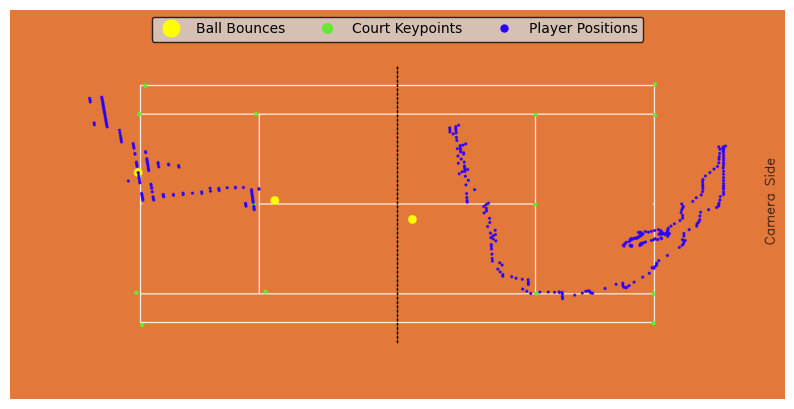

Transfer error: 219.40 pixels


In [16]:
plot_clip(2,1)

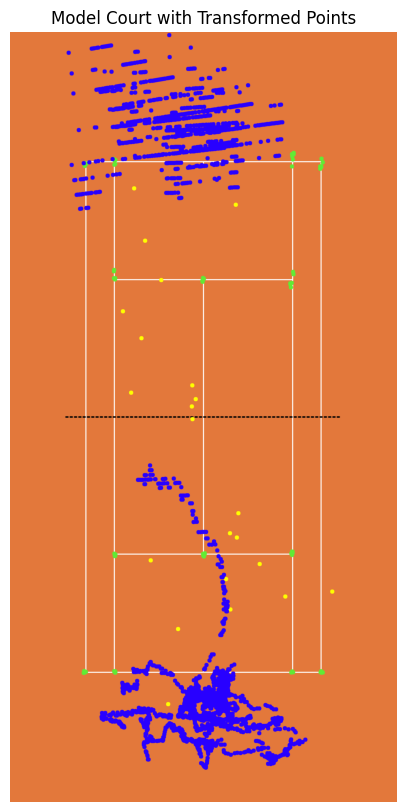

In [17]:
plot_video(4, True, True, True)

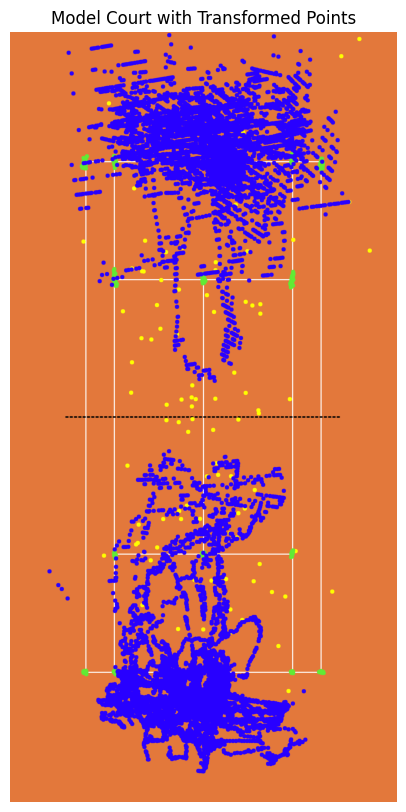

In [18]:
plot_subset(True, True, True)

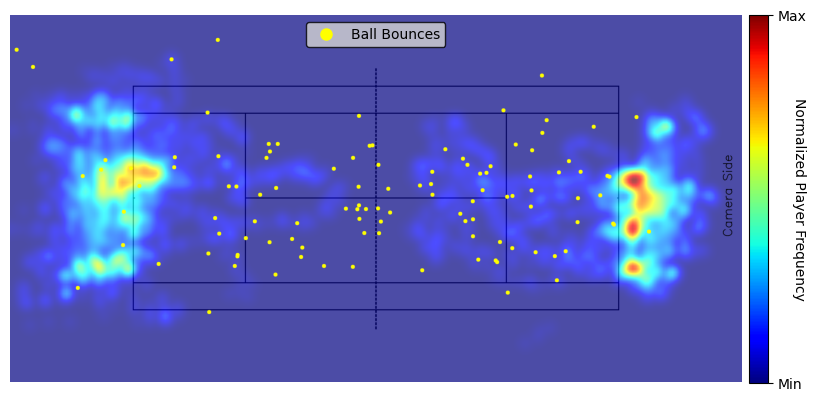

In [20]:
# plot heatmap
plot_subset_heatmap(players=True, court=court_white, gridsize=15)

### calculate MTE

In [21]:
# get error for subset
def get_subset_error(method = 0):
    total_error = 0
    error_df = pd.DataFrame(columns=['video', 'clip', 'error'])
    for video in range(len(data['subsets'][0]['videos'])):
        for clip in range(len(data['subsets'][0]['videos'][video]['clips'])):
            _, _, transfer_error = get_homography_for_clip(video, clip, method)
            # add using loc
            error_df.loc[len(error_df)] = [video, clip, transfer_error]
            total_error += transfer_error
    return total_error, error_df

print(f"Total error for subset method 0: {get_subset_error(0)[0]:.2f} pixels")
print(f"Total error for subset method ransac: {get_subset_error(cv2.RANSAC)[0]:.2f} pixels")
print(f"Total error for subset method lmeds: {get_subset_error(cv2.LMEDS)[0]:.2f} pixels")
print(f"Total error for subset method ransac with USAC_ACCURATE: {get_subset_error(cv2.USAC_ACCURATE)[0]:.2f} pixels")
print(f"Total error for subset method ransac with USAC_FAST: {get_subset_error(cv2.USAC_FAST)[0]:.2f} pixels")
print(f"Total error for subset method ransac with USAC_MAGSAC: {get_subset_error(cv2.USAC_MAGSAC)[0]:.2f} pixels")

Total error for subset method 0: 5885.20 pixels
Total error for subset method ransac: 26531.35 pixels
Total error for subset method lmeds: 15362.33 pixels
Total error for subset method ransac with USAC_ACCURATE: 28800.51 pixels
Total error for subset method ransac with USAC_FAST: 29114.83 pixels
Total error for subset method ransac with USAC_MAGSAC: 23657.58 pixels


In [22]:
# print errors for each clip with 0
errors = get_subset_error(0)[1]

errors.describe()

,video,clip,error
count,35.000000,35.000000,35.000000
mean,2.085714,2.857143,168.148521
std,1.442454,2.074252,100.931349
min,0.000000,0.000000,13.855080
25%,1.000000,1.000000,87.490128
50%,2.000000,3.000000,158.399521
75%,3.000000,4.500000,225.703148
max,5.000000,7.000000,381.804840
